<img src="https://c9k9c9v3.stackpathcdn.com/wp-content/uploads/2018/04/PH-mobile-payment-providers-go-into-acceleration-mode-1440x564_c.jpg?x82653">

### Context

There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

We present a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.

### Content

PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.

### Headers

**Sample Row**

1 | PAYMENT | 1060.31 | C429214117 | 1089.0 | 28.69 | M1591654462 | 0.0 | 0.0 | 0 | 0


**Brief Description of each column**

1. **step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

2. **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

3. **amount** - amount of the transaction in local currency.

4. **nameOrig** - customer who started the transaction

5. **oldbalanceOrg** - initial balance before the transaction

6. **newbalanceOrig** - new balance after the transaction

7. **nameDest** - customer who is the recipient of the transaction

8. **oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

9. **newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

10. **isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

11. **isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction.

### Objective

1. To gain knowledge how fraud transactions are classified
2. To try different techniques to improve model



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv', nrows=90_000)
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
89995,10,PAYMENT,15365.90,C2142225413,354430.00,339064.10,M2046928025,0.00,0.00,0,0
89996,10,PAYMENT,6593.32,C1100408158,147849.00,141255.68,M1301761451,0.00,0.00,0,0
89997,10,DEBIT,2690.61,C1285105648,80975.00,78284.39,C961113212,839678.62,842369.23,0,0
89998,10,PAYMENT,9532.06,C1003190166,11302.00,1769.94,M1300351396,0.00,0.00,0,0


### **I. Exploratory Data Analysis**

#### **Column Information**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            90000 non-null  int64  
 1   type            90000 non-null  object 
 2   amount          90000 non-null  float64
 3   nameOrig        90000 non-null  object 
 4   oldbalanceOrg   90000 non-null  float64
 5   newbalanceOrig  90000 non-null  float64
 6   nameDest        90000 non-null  object 
 7   oldbalanceDest  90000 non-null  float64
 8   newbalanceDest  90000 non-null  float64
 9   isFraud         90000 non-null  int64  
 10  isFlaggedFraud  90000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 7.6+ MB


Based from this info, we could separate the column into:

- **Numerical**: step, amount, oldlbalanceOrig, newbalanceOrig, oldbalanceDest, newbalanceDest

- **Categorical**: type, nameOrig, nameDest, isFlaggedFraud

#### **Checking for rows with missing values**

In [4]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

The dataset doesn't have missing values.

#### **Step**

> **step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).


Due to memory constraints, we can only use a portion of the data. Thus, I decided to drop this for now, and get back to this in the future. For now, we'll try to create a model without this. 

But, I think that this column could be included as one of the features. Specifically, we may use this to get some pattern on when fraud transaction happens. One of the problems that this data may answer is that, *"Is there a certain day or hour where fraud transaction takes place?"*

In [5]:
def drop_column(df, column_name):
    if column_name in df.columns:
        df.drop(column_name, axis=1, inplace=True)
        print(f'{column_name} column is dropped from the given dataframe.')
    else:
        print(f'{column_name} column does not exist in the given dataframe.')

In [6]:
drop_column(df, 'step')

step column is dropped from the given dataframe.


#### **Transaction Type**

>**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

Let's view the distribution for each payment type category

[Text(0.5, 1.0, 'Payment Type Distribution')]

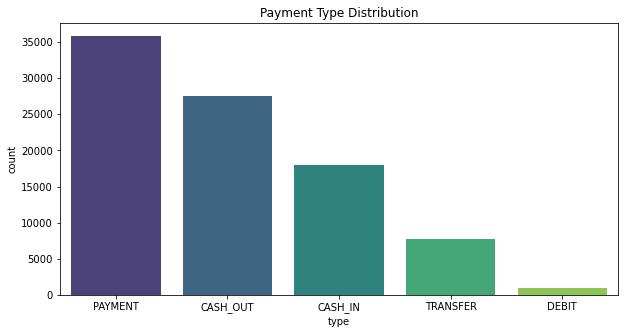

In [7]:
plt.figure(figsize=(10,5))
sns.countplot(
    x = 'type', 
    data = df, 
    palette = 'viridis',
    order = df['type'].value_counts().index
).set(title='Payment Type Distribution')

[Text(0.5, 1.0, 'Fraud Payments per Payment Type Distribution')]

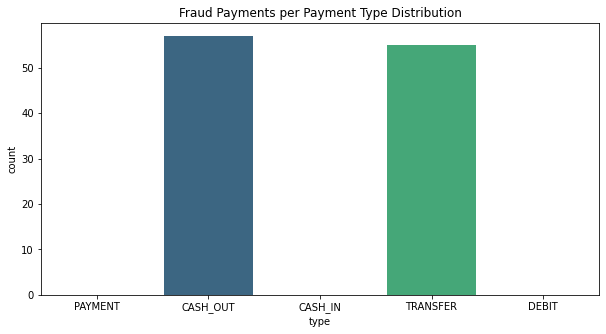

In [8]:
isFraud_df = df[df.isFraud == True]
notFraud_df = df[df.isFraud == False]

plt.figure(figsize=(10,5))
sns.countplot(
    x = 'type', 
    data = isFraud_df, 
    palette = 'viridis',
    order = df['type'].value_counts().index
).set(title='Fraud Payments per Payment Type Distribution')

Findings:

- The most common transaction used is **Payment** (Customer to Merchants)
- The plot shows that **fraud** transactions usually occurs on **cash out** and **transfer** transactions. 
- The act of removing the money from an account by transferring it to another account and then cashing out that money from the system is a potential fraud transaction.

Conclusion:

This column needs to undergo one-hot-encoding for us to be able to use it as a feature for building our model. Once each category got process, I think we don't need to use all categories, and instead just use the cashout and transfer category for our model.

#### **Transaction Amount**

> **amount** - amount of the transaction in local currency.

Assumptions:

- Usually, banks set a certain limit on the amount of transactions an account can have on a day to prevent cases of money laundering. If the account reach the threshold, it usually halts the transaction and the account holder needs to prove first if the money in the transaction is clean before it proceeds. Therefore, transactions with large amount must be flagged as fraud transactions.


Let's try to look at the distribution of amount transaction for fraud and non fraud transactions.

Text(0.5, 1.0, 'Not Fraud Transactions')

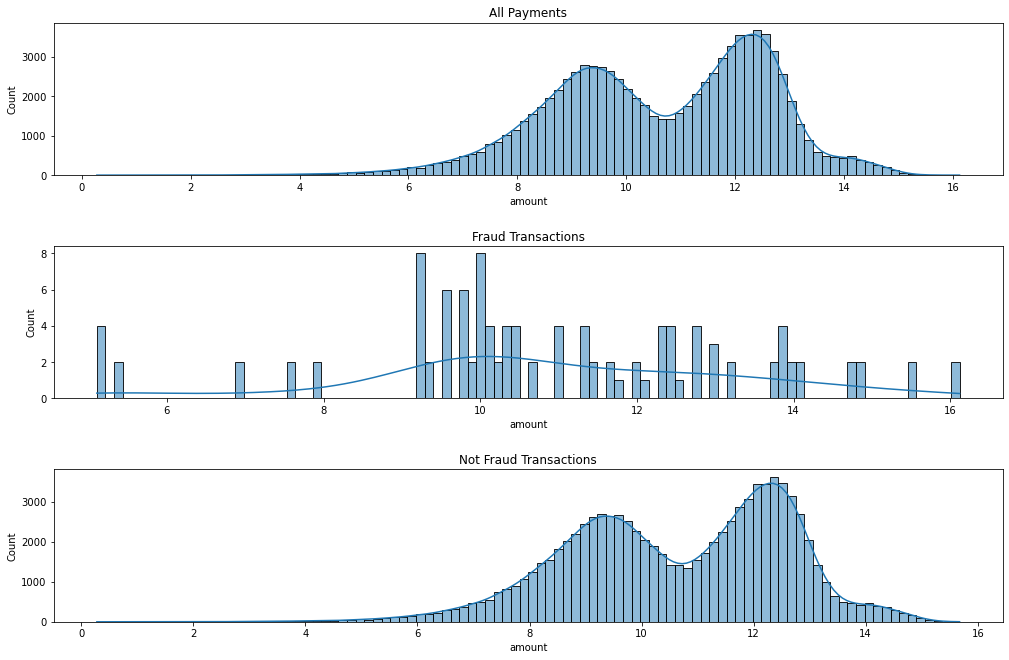

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
fig.tight_layout(pad=5)

transform = np.log(df['amount'] + 1)
sns.histplot(ax=axes[0],data=df, x=transform, kde=True, bins=100).set_title('All Payments')

transform = np.log(isFraud_df['amount'] + 1)
sns.histplot(ax=axes[1],data=isFraud_df, x=transform, kde=True, bins=100).set_title('Fraud Transactions')

transform = np.log(notFraud_df['amount'] + 1)
sns.histplot(ax=axes[2],data=notFraud_df, x=transform, kde=True, bins=100).set_title('Not Fraud Transactions')

Findings:

- Due to the skewness of the distribution, we applied transfromation methods to view the distribution better. 
- The distribution of fraud payments doesn't show some pattern that differentiate it from non fraud payments. 
- It seems that the amount of transaction doesn't matter at all.

Let's check a summary of descriptive statistics of each distributions.

In [10]:
pd.concat([
    df.amount.describe().apply(lambda x: format(x, 'f')),
    isFraud_df.amount.describe().apply(lambda x: format(x, 'f')),
    notFraud_df.amount.describe().apply(lambda x: format(x, 'f'))
], keys=['All', 'Fraud', 'Not Fraud'], axis = 1)

,All,Fraud,Not Fraud
count,90000.000000,112.000000,89888.000000
mean,170090.264532,550255.927857,169616.580010
std,338576.688242,1561291.464092,334045.674980
min,0.320000,164.000000,0.320000
25%,9723.960000,16671.960000,9714.122500
50%,50518.550000,34198.245000,50540.800000
75%,208076.402500,266318.625000,208007.807500
max,10000000.000000,10000000.000000,6419835.270000


Findings:
- The max transaction amount made reached 10,000,000, which is labeled as Fraud.
- The highest transaction that is labeled as Not Fraud amounts to 6,419,835. If our assumption is valid, this must have been flagged as fraud
- The minimum fraud transaction amount is 181. This invalidates any assumptions that fraud transactions are usually high in amount.

Conclusion:

I think that the amount is a weak indicator for predicting fraud transactions for this dataset. Nonetheless, I'll leave it as it might be useful for predicting the extremes from both sides of the distribution.

#### **Old and New Balance of both Receiver and Sender**

>**oldbalanceOrg** - initial balance before the transaction
>
>**newbalanceOrig** - new balance after the transaction
>
>**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
>
>**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).



Initial Assumptions:
1. oldbalanceOrg - newbalanceOrig = amount
2. newbalanceDest - oldbalanceDest = amount
3. If there is a row that doesn't agree in assumption 1 or 2, is it right to assume that it must be fraud?


In [11]:
orig_balance_change = df.oldbalanceOrg - df.newbalanceOrig
is_correct_orig_balance = (df.amount == orig_balance_change)
is_correct_orig_balance.name = 'is_correct_orig_balance'
is_correct_orig_balance.value_counts()

False    83283
True      6717
Name: is_correct_orig_balance, dtype: int64

In [12]:
dest_balance_change = df.newbalanceDest - df.oldbalanceDest
is_correct_dest_balance = df.amount == dest_balance_change
is_correct_dest_balance.name = 'is_correct_dest_balance'
is_correct_dest_balance.value_counts()

False    86446
True      3554
Name: is_correct_dest_balance, dtype: int64

Result:

- Initial assumption 1 and 2 are invalid, the majority of the change in balance doesn't reflect on the amount of the transaction.
- Initial assumption 3 must also be invalid. Since the majority doesn't apply initial assumption 1 and 2, the majority must be fraud for this to be valid. 

Question: If the orig_balance_change and dest_balance_change is equal to the amount, is it safe to assume that the transaction is not fraud?

In [13]:
df3 = pd.concat([
        is_correct_orig_balance, 
        is_correct_dest_balance,
        df.isFraud
    ], 
    axis=1)
df4 = df3[df3['is_correct_orig_balance'] & df3['is_correct_dest_balance']] 
correct_balance_fraud = df4[df4.isFraud == 1]
correct_balance_fraud.head(5)

,is_correct_orig_balance,is_correct_dest_balance,isFraud
1870,True,True,1
2302,True,True,1
3060,True,True,1
4104,True,True,1
4261,True,True,1


Answer: The transaction can be fraud, even if the amount reflects the change on the old balance and new balance. both on orig/sender and dest/receiver

Let's try observing the rows of fraud transactions with correct orig and dest balance.

In [14]:
index_list = correct_balance_fraud.index.tolist()
df.iloc[index_list]

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1870,CASH_OUT,25071.46,C1275464847,25071.46,0.0,C1364913072,9083.76,34155.22,1,0
2302,CASH_OUT,235238.66,C1499825229,235238.66,0.0,C2100440237,0.00,235238.66,1,0
3060,CASH_OUT,1096187.24,C77163673,1096187.24,0.0,C644345897,0.00,1096187.24,1,0
4104,CASH_OUT,10539.37,C1984954272,10539.37,0.0,C124540047,0.00,10539.37,1,0
4261,CASH_OUT,22877.00,C2126545173,22877.00,0.0,C573200870,0.00,22877.00,1,0
4668,CASH_OUT,169941.73,C2026325575,169941.73,0.0,C1394526584,0.00,169941.73,1,0
4694,CASH_OUT,13707.11,C556223230,13707.11,0.0,C2094777811,0.00,13707.11,1,0
4776,CASH_OUT,86070.17,C1699873763,86070.17,0.0,C560041895,0.00,86070.17,1,0
4858,CASH_OUT,120074.73,C1174000532,120074.73,0.0,C410033330,0.00,120074.73,1,0
5467,CASH_OUT,10119.47,C213063852,10119.47,0.0,C922511709,0.00,10119.47,1,0


Observations:

- The type of payment that was used on all rows is CASH_OUT.
- The amount and oldbalanceOrg column values are the same, on all rows.
- This clearly means that emptying the balance of the account and cashing it out is labeled as fraud transaction.

Let's observe the other fraud transactions that does not have correct orig and dest balance, we might get new patterns for fraud transactions.

In [15]:
incorrect_balance_fraud = isFraud_df.drop(index_list, axis=0).sort_values(by='amount', ascending=True)
incorrect_balance_fraud.head(20)

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
12179,TRANSFER,164.00,C1455969984,164.00,0.0,C2119910556,0.00,0.00,1,0
12180,CASH_OUT,164.00,C1173659886,164.00,0.0,C1769947269,4068.00,0.00,1,0
2,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
18771,TRANSFER,222.00,C1961506277,222.00,0.0,C378841819,0.00,267095.19,1,0
18772,CASH_OUT,222.00,C1737727444,222.00,0.0,C588779235,24708.00,171647.35,1,0
69202,CASH_OUT,1055.00,C1764109750,1055.00,0.0,C1522743169,75179.00,0.00,1,0
69201,TRANSFER,1055.00,C666486325,1055.00,0.0,C279565067,0.00,0.00,1,0
24967,CASH_OUT,1996.17,C858959216,1996.17,0.0,C864078397,2559.74,4555.92,1,0
24966,TRANSFER,1996.17,C1198040187,1996.17,0.0,C1828047633,0.00,0.00,1,0


We can still observe the equal values between the amount and oldbalanceOrg column, which denotes fraud transactions. Let's eliminate these rows and find out the remaining rows with fraud transactions.

In [16]:
incorrect_balance_fraud_2 = incorrect_balance_fraud[
    incorrect_balance_fraud['amount'] != incorrect_balance_fraud['oldbalanceOrg'] 
]
incorrect_balance_fraud_2

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1911,CASH_OUT,132842.64,C13692003,4499.08,0.00,C297927961,0.00,132842.64,1,0
14861,CASH_OUT,181728.11,C2102265902,0.00,0.00,C789014007,11397.00,184477.77,1,0
77745,CASH_OUT,277970.88,C489647033,0.00,0.00,C571514738,0.00,277970.88,1,0
724,CASH_OUT,416001.33,C749981943,0.00,0.00,C667346055,102.00,9291619.62,1,0
60853,TRANSFER,994453.20,C1121789613,1437370.87,442917.67,C254839817,194812.76,665743.67,1,0
25875,TRANSFER,1078013.76,C1026280121,0.00,0.00,C277510102,0.00,970749.68,1,0
4440,TRANSFER,10000000.00,C7162498,12930418.44,2930418.44,C945327594,0.00,0.00,1,0


Observations:
    
- In rows with cashout type, the amount to cash out is bigger than oldbalanceOrg, which should not be possible. Additionally, the amount is seems to get through to the receiver, since the newbalanceDest is equal to the amount. Seems to be an outlier.
- There is one case (index 60853), where the amount received by the receiver, is smaller than the amount it supposedly have received.
- On the last row (index 4440), the amount and the sender's change in balance is correct. The old and new balance of receiver is both 0, which can be seen on other transactions as well. Is it labeled as fraud because of its ridiculously high amount of transfer? 


Question: Are there non fraud transactions that have the same amount and oldbalanceOrg, which seems to be the main pattern for fraud transactions?

In [17]:
notFraud_df[notFraud_df['amount'] == notFraud_df['oldbalanceOrg']]

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


Answer: No, there are no non fraud transactions that have the same amount and oldbalanceOrg.

Conclusion:

The difference between amount and oldbalanceOrig seems to be a main predictor whether a transaction is fraud or not. Thus, let's create a column for the difference between amount and oldbalanceOrig. Furthermore, the irregularity with most of the data on oldbalanceDest and newbalanceDest column is unexplainable and doesn't make sense. Thus, I'm omitting these columns for the features that will be use for building the model.

In [18]:
# add new column if not exists
if 'amount_oldbalanceOrg_diff' not in df.columns:
    df['amount_oldbalanceOrg_diff'] = df['oldbalanceOrg'] - df['amount']
df

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_oldbalanceOrg_diff
0,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,160296.36
1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,19384.72
2,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0.00
3,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0.00
4,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,29885.86
...,...,...,...,...,...,...,...,...,...,...,...
89995,PAYMENT,15365.90,C2142225413,354430.00,339064.10,M2046928025,0.00,0.00,0,0,339064.10
89996,PAYMENT,6593.32,C1100408158,147849.00,141255.68,M1301761451,0.00,0.00,0,0,141255.68
89997,DEBIT,2690.61,C1285105648,80975.00,78284.39,C961113212,839678.62,842369.23,0,0,78284.39
89998,PAYMENT,9532.06,C1003190166,11302.00,1769.94,M1300351396,0.00,0.00,0,0,1769.94


In [19]:
drop_column(df, 'oldbalanceDest')
drop_column(df, 'newbalanceDest')

oldbalanceDest column is dropped from the given dataframe.
newbalanceDest column is dropped from the given dataframe.


#### **Sender and Receiver Account Names**

>**nameOrig** - customer who started the transaction
>
>**nameDest** - customer who is the recipient of the transaction

**Assumptions**
1. Sender can't send money to itself!
2. Since fraud payments occurs only on Cashout and Transfer transactions, most, if not all transaction should be from customer to customer.
3. *"In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system."* Based from this statement, recipients of fraud transfers must be on sender of fraud cashouts.


In [20]:
print("Does same sender and receiver in a transaction possible?")
print(df[df.nameOrig == df.nameDest].value_counts().any())

Does same sender and receiver in a transaction possible?
False


In [21]:
senders = df['nameOrig'].astype(str).str[0].unique()
receivers = df['nameDest'].astype(str).str[0].unique()
fraud_senders = isFraud_df['nameOrig'].astype(str).str[0].unique()
fraud_receivers = isFraud_df['nameDest'].astype(str).str[0].unique()

print(f'Sender Types: {senders}')
print(f'Receiver Types: {receivers}')
print(f'Senders of fraud transactions: {fraud_senders}')
print(f'Receivers of fraud transactions: {fraud_receivers}')

Sender Types: ['C']
Receiver Types: ['M' 'C']
Senders of fraud transactions: ['C']
Receivers of fraud transactions: ['C']


In [22]:
pay_type = isFraud_df.type.unique() # ['TRANSFER', 'CASH_OUT']
fraud_transfer = isFraud_df[isFraud_df.type == pay_type[0]]
fraud_cashout = isFraud_df[isFraud_df.type == pay_type[1]]

print('Does a receiver of fraud transfer showed up in sender of fraud cashout?')
print(fraud_transfer.nameDest.isin(fraud_cashout.nameOrig).any())

Does a receiver of fraud transfer showed up in sender of fraud cashout?
False


**Conclusion**
- The dataset doesn't have a row with same nameDest and nameOrig, which can be an outlier.
- Rows with receiver type 'M' can be ruled out as non fraudulent transactions. 
- We'll replace the nameOrig and nameDest column with a column for transactions that have Merchants as its receiver. 

In [23]:
name_dest_category = df['nameDest'].astype(str).str[0]
df['is_receiver_merchant'] = name_dest_category == 'M'
df

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,isFraud,isFlaggedFraud,amount_oldbalanceOrg_diff,is_receiver_merchant
0,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0,0,160296.36,True
1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0,0,19384.72,True
2,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,1,0,0.00,False
3,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,1,0,0.00,False
4,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0,0,29885.86,True
...,...,...,...,...,...,...,...,...,...,...
89995,PAYMENT,15365.90,C2142225413,354430.00,339064.10,M2046928025,0,0,339064.10,True
89996,PAYMENT,6593.32,C1100408158,147849.00,141255.68,M1301761451,0,0,141255.68,True
89997,DEBIT,2690.61,C1285105648,80975.00,78284.39,C961113212,0,0,78284.39,False
89998,PAYMENT,9532.06,C1003190166,11302.00,1769.94,M1300351396,0,0,1769.94,True


In [24]:
drop_column(df, 'nameOrig')
drop_column(df, 'nameDest')

nameOrig column is dropped from the given dataframe.
nameDest column is dropped from the given dataframe.


#### **Flagged as Fraud Transactions**

>**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction.

Let's check the correlation between the isFlaggedFraud and isFraud column

In [25]:
corr_mat = df[['isFraud', 'isFlaggedFraud']].corr()
corr_mat

,isFraud,isFlaggedFraud
isFraud,1.0,NaN
isFlaggedFraud,NaN,NaN


I thought that there would be a correlation between the two columns. From my understanding, this column is an attempt for flagging massive transactions as fraud.

In [26]:
print("Fraud transactions by type: \n",df.isFlaggedFraud.value_counts())

Fraud transactions by type: 
 0    90000
Name: isFlaggedFraud, dtype: int64


Since isFlaggedFraud column indicates that all transactions are not fraud, this will not be useful as a feature for the model.

In [27]:
drop_column(df, 'isFlaggedFraud')

isFlaggedFraud column is dropped from the given dataframe.


#### **Fraud or Not Fraud?**

>**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

In [28]:
col = df['isFraud']
unique_counts = col.value_counts()
relative_freq = col.value_counts(normalize=True)
percentage = relative_freq.mul(100).round(1).astype(str) + '%'
pd.DataFrame({'counts': unique_counts, 'freq': relative_freq, 'percentage': percentage})

,counts,freq,percentage
0,89888,0.998756,99.9%
1,112,0.001244,0.1%


There is a clear imbalance between the two labels. This needs to be balanced to prevent the model to be over-bias towards the majority label. We'll work on balancing out the data once we performed the train-test split on the dataset.

### **II. Feature Engineering and Train-Test Split**

#### **One Hot Encoding**

The categorical column "type" will be one hot encoded, in order to be properly used for our model.  

In [29]:
type_df = pd.get_dummies(df.type, prefix='type')

if ~type_df.columns.isin(df.columns).any():
    df = pd.concat([df, type_df.type_CASH_OUT, type_df.type_TRANSFER], axis=1)
df

,type,amount,oldbalanceOrg,newbalanceOrig,isFraud,amount_oldbalanceOrg_diff,is_receiver_merchant,type_CASH_OUT,type_TRANSFER
0,PAYMENT,9839.64,170136.00,160296.36,0,160296.36,True,0,0
1,PAYMENT,1864.28,21249.00,19384.72,0,19384.72,True,0,0
2,TRANSFER,181.00,181.00,0.00,1,0.00,False,0,1
3,CASH_OUT,181.00,181.00,0.00,1,0.00,False,1,0
4,PAYMENT,11668.14,41554.00,29885.86,0,29885.86,True,0,0
...,...,...,...,...,...,...,...,...,...
89995,PAYMENT,15365.90,354430.00,339064.10,0,339064.10,True,0,0
89996,PAYMENT,6593.32,147849.00,141255.68,0,141255.68,True,0,0
89997,DEBIT,2690.61,80975.00,78284.39,0,78284.39,False,0,0
89998,PAYMENT,9532.06,11302.00,1769.94,0,1769.94,True,0,0


In [30]:
# Dropping type column after one hot encoding
drop_column(df, 'type')

type column is dropped from the given dataframe.


#### **Finding Correlation**

<AxesSubplot:>

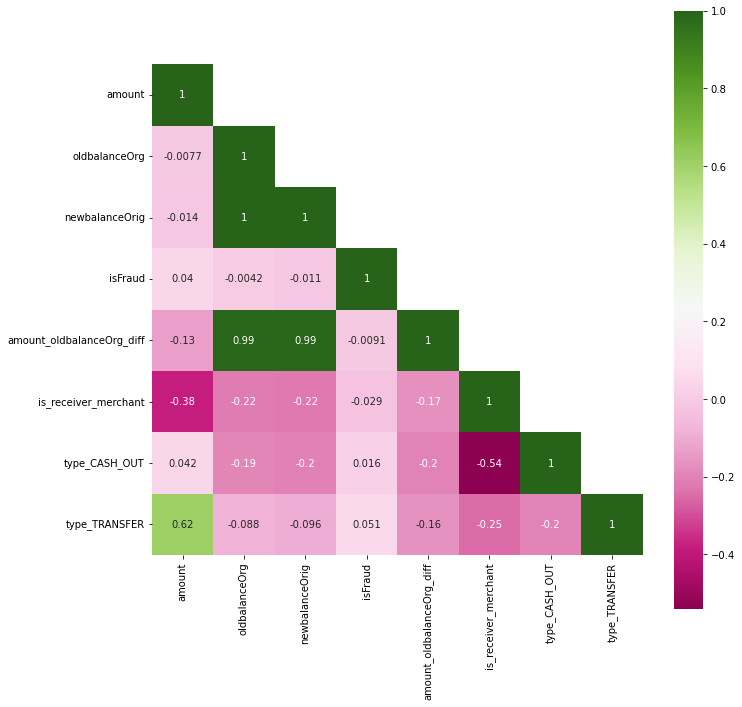

In [31]:
corr_mat = df.corr('pearson')
mask = np.triu(corr_mat, 1)
plt.figure(figsize=(11,11))
sns.heatmap(corr_mat, cmap='PiYG', annot=True, square=True, mask=mask)

#### **Train Test Split**

In [32]:
X = df.drop(['isFraud'], axis=1)
# X = df[['amount_oldbalanceOrg_diff', 'newbalanceOrig']]
y = df.isFraud

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

### **III. Building ML Model**

In [33]:
from sklearn import preprocessing

# ML Classifier Objects
log_reg_clf = LogisticRegression(solver='liblinear', max_iter=1000)
nb_clf = GaussianNB()
knn_clf = KNeighborsClassifier()
prcptrn_clf = Perceptron()
dt_clf=DecisionTreeClassifier()

# ML Classifier Dictionary
clf_dict = {
    'Logistic Regression': log_reg_clf, 
    'Naive Bayes': nb_clf,
    'KNN': knn_clf,
    'Perceptron': prcptrn_clf,
    'Decision Tree': dt_clf
}


def get_model_performances(X_train, y_train):
    log_reg_clf = LogisticRegression(solver='liblinear', max_iter=1000)
    nb_clf = GaussianNB()
    knn_clf = KNeighborsClassifier()
    prcptrn_clf = Perceptron()
    dt_clf=DecisionTreeClassifier()

    clf_dict = {
        'Logistic Regression': log_reg_clf, 
        'Naive Bayes': nb_clf,
        'KNN': knn_clf,
        'Perceptron': prcptrn_clf,
        'Decision Tree': dt_clf
    }

    model_acc = []
    for model in clf_dict.keys():
        y_pred = clf_dict[model].fit(X_train, y_train).predict(X_test)
        test_accuracy = metrics.accuracy_score(y_test, y_pred) * 100
        test_precision = metrics.precision_score(y_test, y_pred, zero_division=1) * 100
        test_recall = metrics.recall_score(y_test, y_pred, zero_division=1) * 100

        model_acc.append({
            'model': model, 
            'test_accuracy': test_accuracy, 
            'test_precision': test_precision,
            'test_recall': test_recall,
        })
        print(model)
        print(confusion_matrix(y_test, y_pred))

    return pd.DataFrame(model_acc).sort_values(by='test_recall', ascending=False)

In [34]:
get_model_performances(X_train, y_train)

Logistic Regression
[[26956     7]
 [    4    33]]
Naive Bayes
[[26894    69]
 [   33     4]]
KNN
[[26958     5]
 [   29     8]]
Perceptron
[[26963     0]
 [   37     0]]
Decision Tree
[[26960     3]
 [    2    35]]


,model,test_accuracy,test_precision,test_recall
4,Decision Tree,99.981481,92.105263,94.594595
0,Logistic Regression,99.959259,82.500000,89.189189
2,KNN,99.874074,61.538462,21.621622
1,Naive Bayes,99.622222,5.479452,10.810811
3,Perceptron,99.862963,100.000000,0.000000


The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


#### **Balancing Data**

https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data

In [35]:
Xy_train = pd.concat([X_train, y_train], axis=1)
Xy_train['isFraud'].value_counts()

0    62925
1       75
Name: isFraud, dtype: int64

In [36]:
from sklearn.utils import resample

majority = Xy_train[Xy_train['isFraud'] == 0]
minority = Xy_train[Xy_train['isFraud'] == 1]

minority_upsampled = resample(
    minority,
    replace = True,
    n_samples = len(majority),
    random_state = 42
)
Xy_train_balanced = pd.concat([majority, minority_upsampled], ignore_index=True)
Xy_train_balanced['isFraud'].value_counts()

0    62925
1    62925
Name: isFraud, dtype: int64

In [37]:
X_train_balanced = Xy_train_balanced.drop('isFraud', axis=1)
y_train_balanced = Xy_train_balanced['isFraud']

In [ ]:
get_model_performances(X_train_balanced, y_train_balanced)

Logistic Regression
[[24038  2925]
 [    2    35]]
Naive Bayes
[[ 4461 22502]
 [    0    37]]
KNN
[[26922    41]
 [    6    31]]
Perceptron
[[23936  3027]
 [    2    35]]


Based from the results, Naive Bayes indeed got the highest recall. However, it has low accuracy and if ever used in a real world environment, it will cause real headache for the personnels who handles false positive cases of fraud transactions. Thus, it would be better to used Logistic Regression, with the second highest recall of 94.6% and having fair accuracy of 88.7%.